### Questions
- What are the different state/country datasets?
  - They are outputs of the simulation it seems...
  - TexasDataCenterSolarModeling.pdf is a saved mathematica notebook output specifically calculating the output NorthTexas2.csv
- What is the plot?
  - X: load capex (\\$/MW), Y: Power system capex (\\$/MWh-load over 10 years)
- I'd need to find the data used for the other cities...
  - It's all here: https://www.nrel.gov/grid/solar-power-data

In [2]:
import os

In [3]:
os.getcwd()

'/Users/alecchen/Documents/Code/solar-modeling'

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
import datetime

In [7]:
import numpy as np

### Download

In [8]:
import os
import requests
import zipfile
import io

DATA_DIR = "data"

eastern_states = ['al', 'ak', 'ct', 'de', 'fl', 'ga', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nh', 'nj', 'nm-east', 'ny', 'nc', 'oh', 'ok', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx-east', 'vt', 'va', 'wv', 'wi']
western_states = ['az', 'ca', 'co', 'id', 'mt', 'nv', 'nm', 'or', 'sd', 'tx', 'ut', 'wa', 'wy']
all_states = eastern_states + western_states

def state_solar_zip_filename(state: str) -> str:
    return f"{state}-pv-2006.zip"

def state_download_url(state: str) -> str:
    return f"https://www.nrel.gov/docs/libraries/grid/{state_solar_zip_filename(state)}"

def state_data_dir(directory: str, state: str) -> str:
    return f"{directory}/{state}"

def download_state_solar_data(directory: str, state: str):
    print("Downloading solar data for", state)
    os.makedirs(directory, exist_ok=True)
    url = state_download_url(state)
    print("url:", url)
    extract_to = state_data_dir(directory, state)
    os.makedirs(extract_to, exist_ok=True)
    r = requests.get(url)
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
    except Exception as e:
        print("Error when creating zip file from content:", e)
        return
    z.extractall(extract_to)
    files = os.listdir(extract_to)
    print(f"Downloaded: {len(os.listdir(extract_to))} total")

def unzip_state_solar_data(directory: str, state: str, zip_path: str):
    os.makedirs(directory, exist_ok=True)
    extract_to = state_data_dir(directory, state)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_to)

def check_downloaded(directory: str, state: str) -> bool:
    state_dir = state_data_dir(directory, state)
    return os.path.isdir(state_dir) and len(os.listdir()) > 0

def download_all_solar_data(directory: str, skip_existing: bool = True):
    for state in all_states:
        if check_downloaded(directory, state) and skip_existing:
            print(f"Already downloaded {state}, skipping...")
            continue
        download_state_solar_data(directory, state)

/Users/alecchen/Documents/Code/solar-modeling/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [9]:
from dataclasses import dataclass
from enum import Enum
import re

class DataType(str, Enum):
    ACTUAL = "Actual" # Real power output
    DA = "DA" # Day ahead forecast
    HA4 = "HA4" # 4 hour ahead forecast

    def __str__(self) -> str:
        return self.value

class PvType(str, Enum):
    UPV = "UPV" # Utility scale PV
    DPV = "DPV" # Distributed PV

    def __str__(self) -> str:
        return self.value

def solar_filename(data_type: DataType, latitude: float, longitude: float, weather_year: int, pv_type: PvType, capacity_mw: float, time_interval_min: int) -> str:
    return f"{data_type}_{round(latitude, 2)}_{round(longitude, 2)}_{weather_year}_{pv_type}_{int(capacity_mw) if capacity_mw.is_integer() else capacity_mw}MW_{time_interval_min}_Min.csv"

@dataclass(frozen=True)
class Dataset:
    data_type: DataType
    latitude: float
    longitude: float
    weather_year: int
    pv_type: PvType
    capacity_mw: float
    time_interval_min: int

    def filename(self) -> str:
        return solar_filename(**self.__dict__)

    @classmethod
    def from_filename(cls, filename: str) -> "Dataset":
        name = filename.removesuffix(".csv")
        parts = name.split("_")

        if len(parts) != 8:  # 8 because of "5_Min" being two parts
            raise ValueError(f"Unexpected filename format: {filename}")

        data_type_str, lat_str, lon_str, year_str, pv_type_str, capacity_str, interval_val, interval_label = parts

        if interval_label != "Min":
            raise ValueError(f"Expected 'Min' at the end of interval, got '{interval_label}'")

        capacity_mw = float(capacity_str[:-2]) # chop the MW
        interval_min = int(interval_val)

        return cls(
            data_type=DataType(data_type_str),
            latitude=float(lat_str),
            longitude=float(lon_str),
            weather_year=int(year_str),
            pv_type=PvType(pv_type_str),
            capacity_mw=capacity_mw,
            time_interval_min=interval_min
        )

example_filename = "Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv"
dataset = Dataset.from_filename(example_filename)
assert dataset.data_type == DataType.ACTUAL
assert dataset.latitude == 33.45
assert dataset.longitude == -112.15
assert dataset.weather_year == 2006
assert dataset.capacity_mw == 103
assert dataset.time_interval_min == 5
assert dataset.filename() == example_filename

example_float_cap_filename = "DA_43.05_-114.85_2006_UPV_0.2MW_60_Min.csv"
dataset_float_cap = Dataset.from_filename(example_float_cap_filename)
assert dataset_float_cap.capacity_mw == 0.2

### File exploration

In [10]:
# download_state_solar_data(DATA_DIR, "az")

In [11]:
download_all_solar_data(DATA_DIR)

Already downloaded al, skipping...
Already downloaded ak, skipping...
Already downloaded ct, skipping...
Already downloaded de, skipping...
Already downloaded fl, skipping...
Already downloaded ga, skipping...
Already downloaded il, skipping...
Already downloaded in, skipping...
Already downloaded ia, skipping...
Already downloaded ks, skipping...
Already downloaded ky, skipping...
Already downloaded la, skipping...
Already downloaded me, skipping...
Already downloaded md, skipping...
Already downloaded ma, skipping...
Already downloaded mi, skipping...
Already downloaded mn, skipping...
Already downloaded ms, skipping...
Already downloaded mo, skipping...
Already downloaded mt, skipping...
Already downloaded ne, skipping...
Already downloaded nh, skipping...
Already downloaded nj, skipping...
Already downloaded nm-east, skipping...
Already downloaded ny, skipping...
Already downloaded nc, skipping...
Already downloaded oh, skipping...
Already downloaded ok, skipping...
Already downloa

In [12]:
example_filename = "Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv"
dataset = Dataset.from_filename(example_filename)
STATE_COL = 'state'
FILENAME_COL = 'filename'
columns = [STATE_COL, FILENAME_COL] + list(dataset.__dict__.keys())

def create_state_files_df() -> pd.DataFrame:
    rows = []
    for state in all_states:
        assert check_downloaded(DATA_DIR, state)
        files = os.listdir(state_data_dir(DATA_DIR, state))
        state_rows = [{STATE_COL: state, FILENAME_COL: file, **Dataset.from_filename(file).__dict__} for file in files]
        rows += state_rows
    return pd.DataFrame(rows)

files_df = create_state_files_df()
empty_states = [state for state in all_states if state not in files_df[STATE_COL].unique()]
print("States with no files:", empty_states)
files_df.head()

States with no files: ['ak', 'oh', 'ok', 'pa', 'ri']


,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
0,al,DA_33.25_-87.45_2006_DPV_39MW_60_Min.csv,DA,33.25,-87.45,2006,DPV,39.0,60
1,al,HA4_34.15_-85.55_2006_UPV_70MW_60_Min.csv,HA4,34.15,-85.55,2006,UPV,70.0,60
2,al,Actual_32.55_-86.55_2006_UPV_40MW_5_Min.csv,Actual,32.55,-86.55,2006,UPV,40.0,5
3,al,Actual_30.75_-87.75_2006_DPV_36MW_5_Min.csv,Actual,30.75,-87.75,2006,DPV,36.0,5
4,al,Actual_34.55_-86.85_2006_DPV_37MW_5_Min.csv,Actual,34.55,-86.85,2006,DPV,37.0,5


In [13]:
len(files_df.loc[files_df["data_type"] == DataType.ACTUAL])

4690

In [14]:
files_df[STATE_COL].value_counts()

state
fl         1779
ca         1215
ga          996
sc          852
tn          816
va          663
mo          588
az          513
ky          477
al          411
ny          387
sd          378
ms          366
il          318
in          303
nj          300
la          279
co          264
mi          252
md          240
nv          231
wa          228
ut          198
tx          168
tx-east     168
ma          150
ks          138
ne          111
mn          108
nc          107
wi           96
ct           87
or           84
nm           81
nm-east      81
ia           75
wv           72
me           69
nh           60
de           48
id           42
mt           24
wy           21
vt           12
Name: count, dtype: int64

### Single state exploration

In [15]:
az_df = files_df.loc[files_df[STATE_COL] == "az"]
az_df.head()

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10610,az,HA4_32.55_-112.05_2006_UPV_100MW_60_Min.csv,HA4,32.55,-112.05,2006,UPV,100.0,60
10611,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
10612,az,HA4_33.85_-112.55_2006_UPV_28MW_60_Min.csv,HA4,33.85,-112.55,2006,UPV,28.0,60
10613,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
10614,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5


In [16]:
len(az_df)

513

In [17]:
actual_df = az_df.loc[az_df["data_type"] == DataType.ACTUAL]
actual_df.head()

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10611,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
10613,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
10614,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10620,az,Actual_33.55_-112.85_2006_UPV_35MW_5_Min.csv,Actual,33.55,-112.85,2006,UPV,35.0,5


In [18]:
len(actual_df)

171

<Axes: >

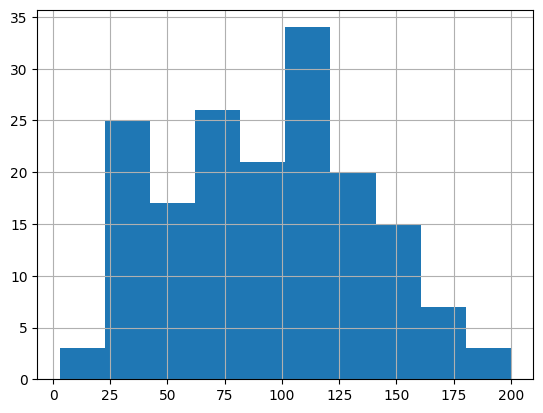

In [19]:
actual_df["capacity_mw"].hist()

In [20]:
actual_df.groupby(by=["weather_year"])["capacity_mw"].sum()

weather_year
2006    15807.0
Name: capacity_mw, dtype: float64

### Actual run some sort of simulation with this

In [21]:
actual_df["capacity_mw"]

10611    103.0
10613    150.0
10614     50.0
10619    100.0
10620     35.0
         ...  
11107    186.0
11109    104.0
11112    103.0
11113      3.0
11120    100.0
Name: capacity_mw, Length: 171, dtype: float64

In [22]:
actual_df.loc[actual_df["capacity_mw"] == actual_df["capacity_mw"].median()]

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10628,az,Actual_34.85_-110.75_2006_UPV_100MW_5_Min.csv,Actual,34.85,-110.75,2006,UPV,100.0,5
10630,az,Actual_33.05_-111.75_2006_UPV_100MW_5_Min.csv,Actual,33.05,-111.75,2006,UPV,100.0,5
10634,az,Actual_33.95_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.95,-114.15,2006,UPV,100.0,5
10646,az,Actual_35.75_-114.65_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.65,2006,UPV,100.0,5
10663,az,Actual_34.15_-113.05_2006_UPV_100MW_5_Min.csv,Actual,34.15,-113.05,2006,UPV,100.0,5
10682,az,Actual_34.55_-114.25_2006_UPV_100MW_5_Min.csv,Actual,34.55,-114.25,2006,UPV,100.0,5
10692,az,Actual_33.65_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.65,-114.15,2006,UPV,100.0,5
10747,az,Actual_33.95_-113.85_2006_UPV_100MW_5_Min.csv,Actual,33.95,-113.85,2006,UPV,100.0,5
10762,az,Actual_35.75_-114.45_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.45,2006,UPV,100.0,5


In [23]:
import folium

US_STATE_CENTERS = {
    'ak': (64.0685, -152.2782),  # Alaska
    'al': (32.7794, -86.8287),   # Alabama
    'az': (34.2744, -111.2847),  # Arizona
    'ca': (36.7783, -119.4179),  # California
    'co': (39.0646, -105.3272),  # Colorado
    'ct': (41.5834, -72.7622),   # Connecticut
    'de': (39.1612, -75.5264),   # Delaware
    'fl': (27.7663, -81.6868),   # Florida
    'ga': (32.9866, -83.6487),   # Georgia
    'ia': (42.0046, -93.2140),   # Iowa
    'id': (44.2394, -114.5103),  # Idaho
    'il': (40.3363, -89.0022),   # Illinois
    'in': (39.8647, -86.2604),   # Indiana
    'ks': (38.5111, -96.8005),   # Kansas
    'ky': (37.6690, -84.6701),   # Kentucky
    'la': (31.1801, -91.8749),   # Louisiana
    'ma': (42.2373, -71.5314),   # Massachusetts
    'md': (39.0724, -76.7902),   # Maryland
    'me': (44.6074, -69.3977),   # Maine
    'mi': (43.3266, -84.5361),   # Michigan
    'mn': (45.7326, -93.9196),   # Minnesota
    'mo': (38.4623, -92.3020),   # Missouri
    'ms': (32.7673, -89.6812),   # Mississippi
    'mt': (47.2529, -110.0044),  # Montana
    'nc': (35.6411, -79.8431),   # North Carolina
    'ne': (41.1289, -98.2883),   # Nebraska
    'nh': (43.4108, -71.5653),   # New Hampshire
    'nj': (40.3140, -74.5089),   # New Jersey
    'nm': (34.8375, -106.2371),  # New Mexico
    'nv': (38.4199, -117.1219),  # Nevada
    'ny': (42.1657, -74.9481),   # New York
    'oh': (40.3736, -82.7755),   # Ohio
    'ok': (35.5376, -96.9247),   # Oklahoma
    'or': (44.5672, -122.1269),  # Oregon
    'pa': (40.5773, -77.2640),   # Pennsylvania
    'ri': (41.6772, -71.5101),   # Rhode Island
    'sc': (33.8191, -80.9066),   # South Carolina
    'sd': (44.2853, -99.4632),   # South Dakota
    'tn': (35.7449, -86.7489),   # Tennessee
    'tx': (31.1060, -97.6475),   # Texas
    'ut': (40.1135, -111.8535),  # Utah
    'va': (37.7680, -78.2057),   # Virginia
    'vt': (44.0407, -72.7093),   # Vermont
    'wa': (47.3917, -121.5708),  # Washington
    'wi': (44.2619, -89.6165),   # Wisconsin
    'wv': (38.4680, -80.9696),   # West Virginia
    'wy': (42.7475, -107.2085)   # Wyoming
}

def plot_with_folium(state: str):
    # Center map on Arizona
    center = US_STATE_CENTERS[state]
    
    # Create map
    m = folium.Map(location=center, zoom_start=7)
    
    # Add markers
    actual_state_df = files_df.loc[(files_df["data_type"] == DataType.ACTUAL) & (files_df[STATE_COL] == state)]
    coordinates = zip(actual_state_df["latitude"], actual_state_df["longitude"])
    for i, (lat, lon) in enumerate(coordinates):
        folium.Marker(
            [lat, lon],
            popup=f'Point {i+1}: ({lat}, {lon})',
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(m)
    
    # Save map
    m.save(f'{state}_map.html')
    print(f"Map saved as '{state}_map.html' - open in browser to view")
    return m

In [24]:
plot_with_folium("az")

Map saved as 'az_map.html' - open in browser to view


In [25]:
plot_with_folium("ca")

Map saved as 'ca_map.html' - open in browser to view


In [26]:
plot_with_folium("il")

Map saved as 'il_map.html' - open in browser to view


In [27]:
# Things left to do
# - compute the solar utilization
# - find the minimum for that certain cost function...
# - run the sims...

### Solar utilization of a single plant

In [28]:
# Goal: plot the power generation over a day

In [29]:
actual_df = files_df.loc[(files_df["data_type"] == DataType.ACTUAL) & (files_df[STATE_COL] == "az")]
# actual_df = files_df.loc[(files_df["data_type"] == DataType.ACTUAL) & (files_df[STATE_COL] == "il")]
actual_df.head()

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10611,az,Actual_33.45_-112.15_2006_DPV_103MW_5_Min.csv,Actual,33.45,-112.15,2006,DPV,103.0,5
10613,az,Actual_34.65_-114.15_2006_UPV_150MW_5_Min.csv,Actual,34.65,-114.15,2006,UPV,150.0,5
10614,az,Actual_32.85_-112.25_2006_UPV_50MW_5_Min.csv,Actual,32.85,-112.25,2006,UPV,50.0,5
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10620,az,Actual_33.55_-112.85_2006_UPV_35MW_5_Min.csv,Actual,33.55,-112.85,2006,UPV,35.0,5


In [30]:
median_cap_df = actual_df.loc[actual_df["capacity_mw"] == actual_df["capacity_mw"].median()]
median_cap_df
# median_cap_df = actual_df.loc[(actual_df["latitude"] == 41.75) & (actual_df["longitude"] == -87.95)]
# median_cap_df

,state,filename,data_type,latitude,longitude,weather_year,pv_type,capacity_mw,time_interval_min
10619,az,Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv,Actual,36.05,-113.95,2006,UPV,100.0,5
10628,az,Actual_34.85_-110.75_2006_UPV_100MW_5_Min.csv,Actual,34.85,-110.75,2006,UPV,100.0,5
10630,az,Actual_33.05_-111.75_2006_UPV_100MW_5_Min.csv,Actual,33.05,-111.75,2006,UPV,100.0,5
10634,az,Actual_33.95_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.95,-114.15,2006,UPV,100.0,5
10646,az,Actual_35.75_-114.65_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.65,2006,UPV,100.0,5
10663,az,Actual_34.15_-113.05_2006_UPV_100MW_5_Min.csv,Actual,34.15,-113.05,2006,UPV,100.0,5
10682,az,Actual_34.55_-114.25_2006_UPV_100MW_5_Min.csv,Actual,34.55,-114.25,2006,UPV,100.0,5
10692,az,Actual_33.65_-114.15_2006_UPV_100MW_5_Min.csv,Actual,33.65,-114.15,2006,UPV,100.0,5
10747,az,Actual_33.95_-113.85_2006_UPV_100MW_5_Min.csv,Actual,33.95,-113.85,2006,UPV,100.0,5
10762,az,Actual_35.75_-114.45_2006_UPV_100MW_5_Min.csv,Actual,35.75,-114.45,2006,UPV,100.0,5


In [31]:
# Just take the first median capacity plan
row = median_cap_df.iloc[0]
print(row[FILENAME_COL])
df = pd.read_csv(f"{DATA_DIR}/{row[STATE_COL]}/{row[FILENAME_COL]}")
df = df.rename(columns={"LocalTime": "local_time", "Power(MW)": "power_mw"})
df["local_time"] = pd.to_datetime(df["local_time"], format="%m/%d/%y %H:%M")
df.head()

Actual_36.05_-113.95_2006_UPV_100MW_5_Min.csv


,local_time,power_mw
0,2006-01-01 00:00:00,0.0
1,2006-01-01 00:05:00,0.0
2,2006-01-01 00:10:00,0.0
3,2006-01-01 00:15:00,0.0
4,2006-01-01 00:20:00,0.0


In [32]:
df["power_mw"].describe()

count    105120.000000
mean         25.880631
std          31.626285
min           0.000000
25%           0.000000
50%           0.000000
75%          61.800000
max          99.900000
Name: power_mw, dtype: float64

In [33]:
len(df)

105120

In [34]:
# 1 day = X 5min intervals = X rows
24 * 60 / 5

288.0

In [35]:
len(df) / 288

365.0

In [36]:
day_df = df.loc[df["local_time"].dt.date == datetime.date(2006, 1, 1)]
len(day_df)

288

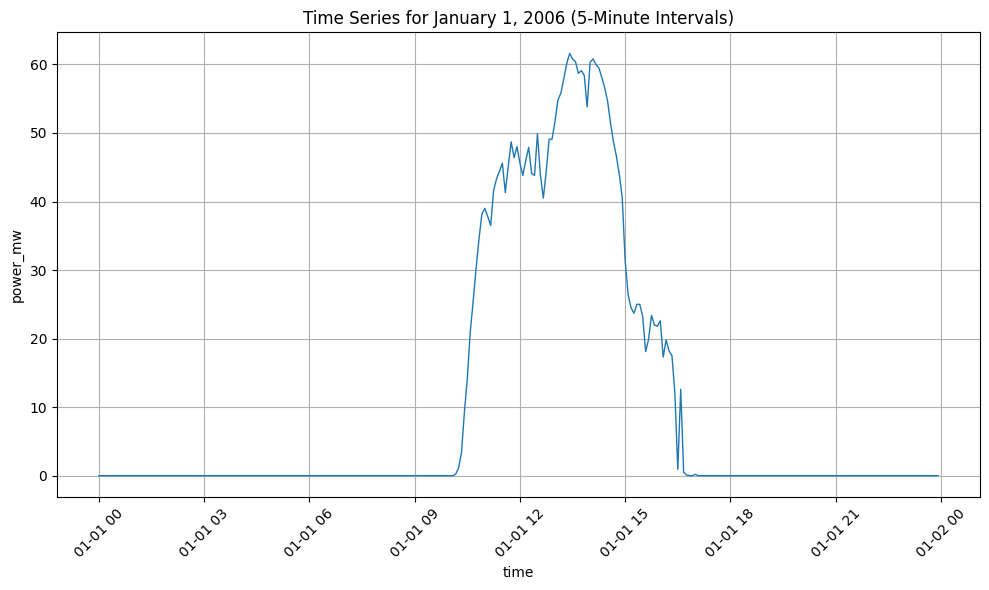

In [37]:
import matplotlib.pyplot as plt

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(day_df['local_time'], day_df['power_mw'], linestyle='-', linewidth=1)
plt.title('Time Series for January 1, 2006 (5-Minute Intervals)')
plt.xlabel('time')
plt.ylabel('power_mw')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
df['date'] = df['local_time'].dt.date
df['time'] = df['local_time'].dt.strftime('%H:%M')
df.head()

,local_time,power_mw,date,time
0,2006-01-01 00:00:00,0.0,2006-01-01,00:00
1,2006-01-01 00:05:00,0.0,2006-01-01,00:05
2,2006-01-01 00:10:00,0.0,2006-01-01,00:10
3,2006-01-01 00:15:00,0.0,2006-01-01,00:15
4,2006-01-01 00:20:00,0.0,2006-01-01,00:20


In [39]:
df_pivot = df.pivot(index='time', columns='date', values='power_mw')
df_pivot

date,2006-01-01,2006-01-02,2006-01-03,2006-01-04,2006-01-05,2006-01-06,2006-01-07,2006-01-08,2006-01-09,2006-01-10,...,2006-12-22,2006-12-23,2006-12-24,2006-12-25,2006-12-26,2006-12-27,2006-12-28,2006-12-29,2006-12-30,2006-12-31
time,,,,,,,,,,,,,,,,,,,,,
00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23:45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


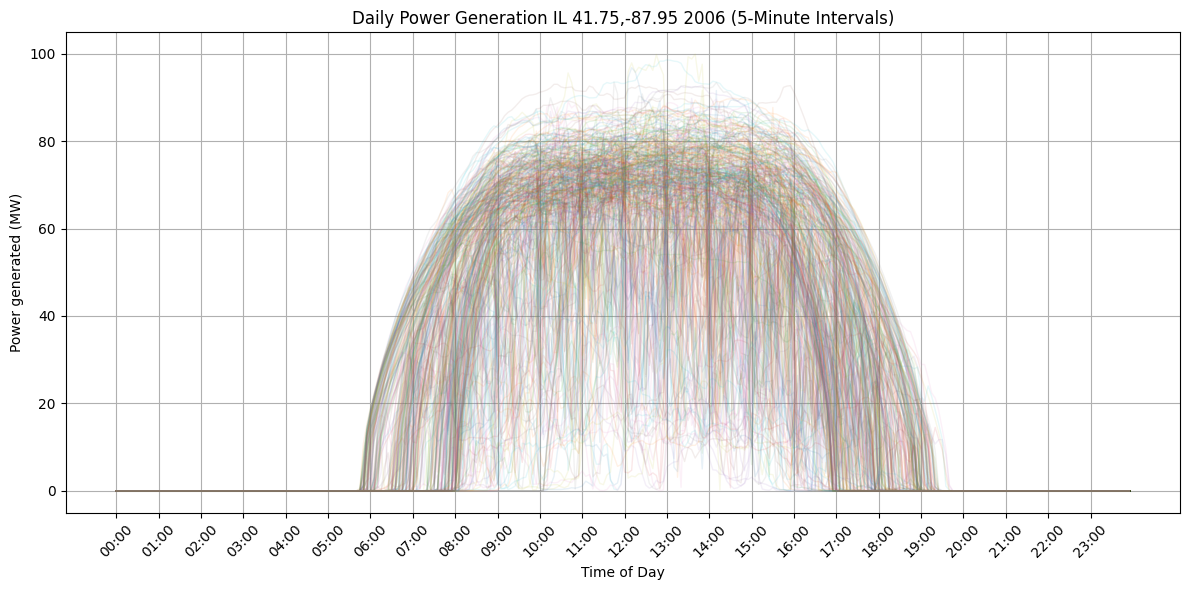

In [40]:
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], alpha=0.1, linewidth=1)

plt.title('Daily Power Generation IL 41.75,-87.95 2006 (5-Minute Intervals)')
plt.xlabel('Time of Day')
plt.ylabel('Power generated (MW)')
plt.grid(True)
plt.xticks(df_pivot.index[::12], rotation=45)  # Show every 12th time (hourly)
plt.tight_layout()
plt.show()

In [41]:
# Mean utilization
df.head()

,local_time,power_mw,date,time
0,2006-01-01 00:00:00,0.0,2006-01-01,00:00
1,2006-01-01 00:05:00,0.0,2006-01-01,00:05
2,2006-01-01 00:10:00,0.0,2006-01-01,00:10
3,2006-01-01 00:15:00,0.0,2006-01-01,00:15
4,2006-01-01 00:20:00,0.0,2006-01-01,00:20


In [42]:
mean_util = df["power_mw"].mean() / row["capacity_mw"] * 100
print(f"{mean_util:.2f}%")

25.88%


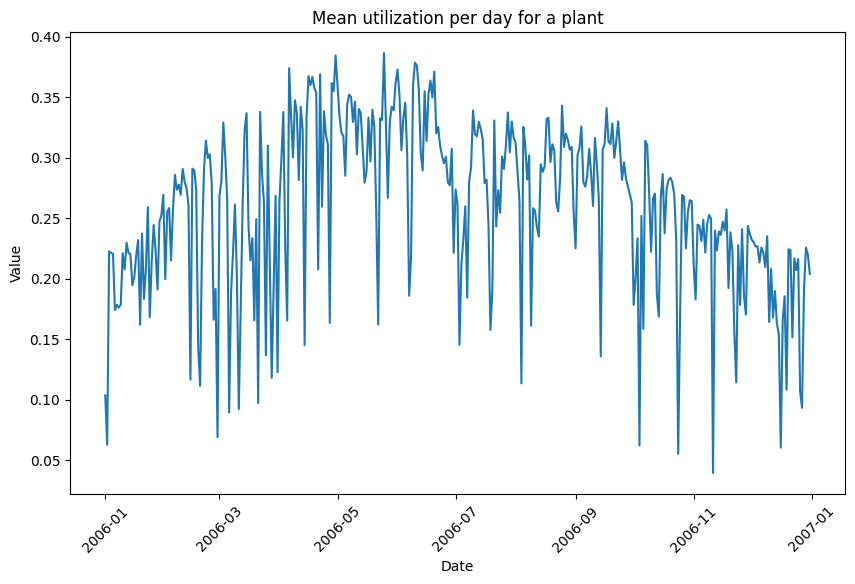

In [43]:
day_df = (df.groupby(by=["date"])["power_mw"].mean() / row["capacity_mw"]).reset_index()

plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(day_df['date'], day_df['power_mw'])  # Line plot with markers
plt.title('Mean utilization per day for a plant')  # Add title
plt.xlabel('Date')  # Label x-axis
plt.ylabel('Value')  # Label y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()  # Display the plot

### Simulating capex

Some questions to keep in mind
- Are we accounting for battery degradation?
- Where did the 200,000/MW assumption come from? How does it hold up to reality?
- TODO: run the experiment for a state by averaging all of it's plants

#### Given this solar plant, how would it perform for different battery capacities and loads?

In [44]:
def uptime_with_battery(caps: np.array, loads: np.array, sol: np.array) -> pd.DataFrame:
    """
    Simulates battery storage system to compute uptime and utilization.

    An assumption here is that load is constant, when in reality it fluctuates.
    It would be really cool to get a load data set to fill in the variability
    across each part of the day/year.

    Can also simulate as no battery system if caps are all zero.
    
    Parameters:
    caps (list or array): List of battery capacities (xWh).
    loads (list or array): List of load demands (xW).
    sol (list or array): Solar generation (xW) over time steps.

    Important thing here is that all parameters are in the same kW vs mW vs etc. unit.
    
    Returns:
    numpy.ndarray: Array with shape (4, len(caps), len(loads)) containing:
        - Battery capacities
        - Load demands
        - Uptime (fraction of time battery is non-empty)
        - Utilization (fraction of load met)
    """
    # Initialize arrays
    n_steps = len(sol)
    n_caps = len(caps)
    n_loads = len(loads)
    time_step = 8760 / n_steps  # Time step in hours since capacity is in xWh
    
    # 3D array for battery state: [time steps, capacities, loads]
    batt = np.full((n_steps, n_caps, n_loads), caps[:, np.newaxis])
    
    # 3D array for utilization, initialized to zeros
    util = np.zeros_like(batt)
    
    # 2D matrices for loads and capacities
    loadsmat = np.tile(loads, (n_caps, 1))  # [caps, loads]
    capsmat = np.tile(caps[:, np.newaxis], (1, n_loads))  # [caps, loads]
    
    # Main loop over time steps
    for i in range(n_steps - 1):
        # Solar discretization: 1 if solar >= load, 0 otherwise
        # sundisc = 0.5 + 0.5 * np.sign(sol[i] - loadsmat)
        sundisc = (sol[i] >= loadsmat).astype(int)
        
        # Battery discharge discretization: 1 if battery can cover shortfall
        # Make sure that we don't accidentally add to battery if solar exceeds load
        # battdisc = 0.5 + 0.5 * np.sign(batt[i] - time_step * (loadsmat - sol[i]))
        battdisc = (batt[i] >= time_step * np.maximum(loadsmat - sol[i], 0.)).astype(int)
        
        # Utilization update
        util[i] = (sundisc + 
                   (1 - sundisc) * battdisc + 
                   (1 - sundisc) * (1 - battdisc) * 
                   (sol[i] / loadsmat + batt[i] / (time_step * loadsmat)))
        
        # Battery state update
        batt[i + 1] = (sundisc * (batt[i] + time_step * (sol[i] - loadsmat)) + 
                       (1 - sundisc) * battdisc * (batt[i] - time_step * (loadsmat - sol[i])) + 
                       (1 - sundisc) * (1 - battdisc) * 0.) # 0 case here just to explicitly show else clause

        # Apply capacity constraint
        # NOTE: important difference between this and reference,
        # we need to compute capdisc on the next battery state not the current.
        # This fixes a bug where we get "uptime" even when we pass in
        # a battery with capacity 0.
        batt[i + 1] = np.minimum(batt[i + 1], capsmat)

    # Compute uptime (fraction of time battery is non-empty)
    uptime = np.mean(np.sign(batt), axis=0)
    
    # Compute utilization (fraction of load met)
    utilization = np.mean(util, axis=0)
    
    # Create DataFrame
    # Flatten capsmat, loadsmat, uptime, and utilization for DataFrame
    caps_flat = capsmat.flatten()
    loads_flat = loadsmat.flatten()
    uptime_flat = uptime.flatten()
    utilization_flat = utilization.flatten()
    
    # Construct DataFrame
    df = pd.DataFrame({
        'capacity': caps_flat,
        'load': loads_flat,
        'uptime': uptime_flat,
        'utilization': utilization_flat
    })
    
    return df

no_battery_example = uptime_with_battery(np.array([0]), np.array([10]), np.array([20, 20]))
assert no_battery_example.iloc[0]["uptime"] == 0.

In [45]:
np.array([10, 20])[:, np.newaxis]

array([[10],
       [20]])

In [46]:
caps = np.array([10, 20])
loads = np.array([1, 2])
sol = np.array([1, 2, 3, 4])

n_steps = len(sol)
n_caps = len(caps)
n_loads = len(loads)
time_step = 8760 / n_steps  # Time step in hours since capacity is in xWh

# 3D array for battery state: [time steps, capacities, loads]
batt = np.full((n_steps, n_caps, n_loads), caps[:, np.newaxis])

# 3D array for utilization, initialized to zeros
util = np.zeros_like(batt)

# 2D matrices for loads and capacities
loadsmat = np.tile(loads, (n_caps, 1))  # [caps, loads]
capsmat = np.tile(caps[:, np.newaxis], (1, n_loads))  # [caps, loads]

batt[0] = capsmat

In [47]:
np.full((10, 2, 3), np.array([10, 20])[:, np.newaxis])

array([[[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]],

       [[10, 10, 10],
        [20, 20, 20]]])

In [48]:
%%time
caps = np.array(list(range(10)))
loads = np.array(list(range(1, 10)))
# sol = np.random.rand(8760) * 15  # 8760 hours of random solar data
sol = df["power_mw"]
result = uptime_with_battery(caps, loads, sol)
result

CPU times: user 3.15 s, sys: 37.2 ms, total: 3.18 s
Wall time: 3.19 s


,capacity,load,uptime,utilization
0,0,1,0.000000,0.458210
1,0,2,0.000000,0.455213
2,0,3,0.000000,0.453311
3,0,4,0.000000,0.451760
4,0,5,0.000000,0.450447
...,...,...,...,...
85,9,5,0.474534,0.485122
86,9,6,0.472812,0.484161
87,9,7,0.471128,0.483419
88,9,8,0.469654,0.482629


In [146]:
def uptime_with_battery_with_inputs(load: float, battery_sizes: np.array, array_sizes: np.array, sol: np.array) -> pd.DataFrame:
    """
    Simulates battery storage system to compute uptime and utilization.

    An assumption here is that load is constant, when in reality it fluctuates.
    It would be really cool to get a load data set to fill in the variability
    across each part of the day/year.

    Can also simulate as no battery system if caps are all zero.
    
    Parameters:
    caps (list or array): List of battery capacities (xWh).
    loads (list or array): List of load demands (xW).
    sol (list or array): Solar generation (xW) over time steps.

    Important thing here is that all parameters are in the same kW vs mW vs etc. unit.
    
    Returns:
    numpy.ndarray: Array with shape (4, len(caps), len(loads)) containing:
        - Battery capacities
        - Load demands
        - Uptime (fraction of time battery is non-empty)
        - Utilization (fraction of load met)
    """
    # Initialize arrays
    n_steps = len(sol)
    n_battery_sizes = len(battery_sizes)
    n_array_sizes = len(array_sizes)
    time_step = 8760 / n_steps  # Time step in hours since capacity is in xWh

    # 2D matrices for loads and capacities
    # Normalize by array_sizes to avoid scaling many sols for each array_size
    loadsmat = np.tile(load / array_sizes, (n_battery_sizes, 1))  # [caps, loads]
    capsmat = np.tile(battery_sizes[:, np.newaxis], (1, n_array_sizes)) / loadsmat  # [caps, loads]

    array_size_mat = np.tile(array_sizes, (n_battery_sizes, 1))  # [caps, loads]
    battery_size_mat = np.tile(battery_sizes[:, np.newaxis], (1, n_array_sizes))  # [caps, loads]

    # 3D array for battery state: [time steps, capacities, loads]
    batt = np.zeros((n_steps, n_battery_sizes, n_array_sizes))
    batt[0] = capsmat # Batteries start full
    
    # 3D array for utilization, initialized to zeros
    util = np.zeros_like(batt)
    
    # Main loop over time steps
    for i in range(n_steps - 1):
        # Solar discretization: 1 if solar >= load, 0 otherwise
        # sundisc = 0.5 + 0.5 * np.sign(sol[i] - loadsmat)
        sundisc = (sol[i] >= loadsmat).astype(int)
        
        # Battery discharge discretization: 1 if battery can cover shortfall
        # Make sure that we don't accidentally add to battery if solar exceeds load
        # battdisc = 0.5 + 0.5 * np.sign(batt[i] - time_step * (loadsmat - sol[i]))
        battdisc = (batt[i] >= time_step * np.maximum(loadsmat - sol[i], 0.)).astype(int)
        
        # Utilization update
        util[i] = (sundisc + 
                   (1 - sundisc) * battdisc + 
                   (1 - sundisc) * (1 - battdisc) * 
                   (sol[i] / loadsmat + batt[i] / (time_step * loadsmat)))
        
        # Battery state update
        batt[i + 1] = (sundisc * (batt[i] + time_step * (sol[i] - loadsmat)) + 
                       (1 - sundisc) * battdisc * (batt[i] - time_step * (loadsmat - sol[i])) + 
                       (1 - sundisc) * (1 - battdisc) * 0.) # 0 case here just to explicitly show else clause

        # Apply capacity constraint
        # NOTE: important difference between this and reference,
        # we need to compute capdisc on the next battery state not the current.
        # This fixes a bug where we get "uptime" even when we pass in
        # a battery with capacity 0.
        batt[i + 1] = np.minimum(batt[i + 1], capsmat)

    # Compute uptime (fraction of time battery is non-empty)
    uptime = np.mean(np.sign(batt), axis=0)
    
    # Compute utilization (fraction of load met)
    utilization = np.mean(util, axis=0)
    
    # Create DataFrame
    # Flatten capsmat, loadsmat, uptime, and utilization for DataFrame
    battery_size_flat = battery_size_mat.flatten()
    array_size_flat = array_size_mat.flatten()
    caps_flat = capsmat.flatten()
    loads_flat = loadsmat.flatten()
    uptime_flat = uptime.flatten()
    utilization_flat = utilization.flatten()
    
    # Construct DataFrame
    df = pd.DataFrame({
        'battery_size': battery_size_flat,
        'array_size': array_size_flat,
        'capacity': caps_flat,
        'load': loads_flat,
        'uptime': uptime_flat,
        'utilization': utilization_flat
    })
    
    return df

no_battery_example = uptime_with_battery_with_inputs(1, np.array([0]), np.array([10]), np.array([20, 20]))
assert no_battery_example.iloc[0]["uptime"] == 0.

In [148]:
uptime_with_battery_with_inputs(1, np.array([10, 20]), np.array([0.2, 0.5, 1, 2]), df["power_mw"] / row["capacity_mw"])

,battery_size,array_size,capacity,load,uptime,utilization
0,10,0.2,2.0,5.0,0.000048,0.051807
1,10,0.5,5.0,2.0,0.000295,0.129689
2,10,1.0,10.0,1.0,0.001142,0.259948
3,10,2.0,20.0,0.5,0.478291,0.522179
4,20,0.2,4.0,5.0,0.000095,0.051853
5,20,0.5,10.0,2.0,0.000580,0.129974
6,20,1.0,20.0,1.0,0.002568,0.261089
7,20,2.0,40.0,0.5,0.483096,0.526745


#### How much would this cost (per "productivity")?

In [149]:
def all_in_system_cost(solarcost: float, batterycost: float, loadcost: float, batterysize: float, arraysize: float, sol: np.array):
    """
    Computes total system cost per unit of productivity (i.e. MW).
    
    Parameters:
    solarcost: Cost per MW of solar array ($/MW).
    batterycost: Cost per MWh of battery ($/MWh).
    loadcost: Cost per MW of load ($/MW).
    batterysize: Battery capacity (MWh).
    arraysize: Solar array capacity (MW).
    sol: Solar generation profile (MW, normalized for 1 MW array).
    
    Returns:
    float: Cost per unit of productivity ($/MW).
    """
    # Call Uptime with normalized inputs
    # TODO: I don't fully understand why/how this normalization works
    result = uptime_with_battery(np.array([batterysize / arraysize]), np.array([1 / arraysize]), sol)
    # Extract capacity, load, uptime, utilization for the single combination
    capacity, load, uptime, utilization = result.iloc[0][['capacity', 'load', 'uptime', 'utilization']]
    
    return (capacity * batterycost + solarcost + loadcost * load) / (load * utilization)

# Example
solarcost = 200000  # $/MW
batterycost = 200000  # $/MWh
loadcost = 5000000  # $/MW
batterysize = 10  # MWh
arraysize = 1  # MW
sol = df["power_mw"] # MW
cost = all_in_system_cost(solarcost, batterycost, loadcost, batterysize, arraysize, sol)
print(cost)

8176373.488665533


In [150]:
def all_in_system_cost_parallel(solarcost: float, batterycost: float, loadcost: float, load: float, batterysize: np.array, arraysize: np.array, sol: np.array) -> np.array:
    result = uptime_with_battery_with_inputs(load, batterysize, arraysize, sol)
    capacity = result["capacity"]
    load = result["load"]
    uptime = result["uptime"]
    utilization = result["utilization"]
    result["cost"] = (capacity * batterycost + solarcost + loadcost * load) / (load * utilization)
    return result

result = all_in_system_cost_parallel(200000, 200000, 5000000, 1, np.array([10, 15]), np.array([1, 5]), df["power_mw"] / row["capacity_mw"])
result

,battery_size,array_size,capacity,load,uptime,utilization,cost
0,10,1,10.0,1.0,0.001142,0.259948,2.769786e+07
1,10,5,50.0,0.2,1.000000,0.999990,5.600053e+07
2,15,1,15.0,1.0,0.001998,0.260519,3.147568e+07
3,15,5,75.0,0.2,1.000000,0.999990,8.100077e+07


In [151]:
%%time
all_in_system_cost_parallel(200000, 200000, 5000000, 1, np.array(list(range(10))), np.array(list(range(1, 11))), df["power_mw"] / row["capacity_mw"])

CPU times: user 2.6 s, sys: 73 ms, total: 2.67 s
Wall time: 2.89 s


,battery_size,array_size,capacity,load,uptime,utilization,cost
0,0,1,0.0,1.000000,0.0,0.258806,2.009225e+07
1,0,2,0.0,0.500000,0.0,0.397848,1.357302e+07
2,0,3,0.0,0.333333,0.0,0.422905,1.324175e+07
3,0,4,0.0,0.250000,0.0,0.434111,1.336063e+07
4,0,5,0.0,0.200000,0.0,0.440515,1.362043e+07
...,...,...,...,...,...,...,...
95,9,6,54.0,0.166667,1.0,0.999990,7.100068e+07
96,9,7,63.0,0.142857,1.0,0.999990,9.460090e+07
97,9,8,72.0,0.125000,1.0,0.999990,1.218012e+08
98,9,9,81.0,0.111111,1.0,0.999990,1.526015e+08


In [144]:
df["power_mw"].describe()

count    105120.000000
mean         25.880631
std          31.626285
min           0.000000
25%           0.000000
50%           0.000000
75%          61.800000
max          99.900000
Name: power_mw, dtype: float64

In [152]:
# TODO: how is it possible to achieve a 0.45 utilization with array_size 0.2 and no battery with 5.0 MW load...
all_in_system_cost_parallel(200000, 200000, 10_000, 1, np.array([0., 0.5]), np.array([0.2, 1.0]), df["power_mw"] / row["capacity_mw"])

,battery_size,array_size,capacity,load,uptime,utilization,cost
0,0.0,0.2,0.0,5.0,0.000000,0.051761,9.659734e+05
1,0.0,1.0,0.0,1.0,0.000000,0.258806,8.114176e+05
2,0.5,0.2,0.1,5.0,0.000010,0.051764,1.043205e+06
3,0.5,1.0,0.5,1.0,0.000067,0.258863,1.197543e+06


In [160]:
def find_minimum_system_cost_parallel(
    solarcost: float,
    batterycost: float,
    loadcost: float,
    load: float,
    sol: np.array
) -> tuple[list[float], list[float], list[float], list[float], list[float]]:

    steps = [10, 1, 0.1, 0.01]
    range_count = 10
    battery_size = steps[0] * range_count / 2
    array_size = steps[0] * range_count / 2
    min_cost = 99999999999999
    best_row = None
    for step in steps:
        battery_sizes = np.array([max(x, 0) for x in list(np.arange(battery_size - step * range_count/2, battery_size + step * range_count/2 + step, step))])
        array_sizes = np.array([max(x, step/10) for x in list(np.arange(array_size - step * range_count/2, array_size + step * range_count/2 + step, step))])
        costs = all_in_system_cost_parallel(solarcost, batterycost, loadcost, load, battery_sizes, array_sizes, sol)
        best_rows = costs.loc[costs["cost"] == costs["cost"].min()]
        # assert len(best_rows) == 1
        best_row = best_rows.iloc[0]
        assert best_row["cost"] <= min_cost
        min_cost = best_row["cost"]
        battery_size = best_row["battery_size"]
        array_size = best_row["array_size"]
        assert min_cost >= 0
    
    return (
        [solarcost, batterycost, loadcost],
        [array_size, battery_size, 1.0],
        [solarcost * array_size, batterycost * battery_size, loadcost],
        [solarcost * array_size + batterycost * battery_size, 
         solarcost * array_size + batterycost * battery_size + loadcost, 
         min_cost],
        best_row.drop(["battery_size", "array_size", "cost"], axis=0).to_list()
    )

In [154]:
%%time
result = find_minimum_system_cost_parallel(200_000, 200_000, 10_000, 1, df["power_mw"] / row["capacity_mw"])
result

CPU times: user 10.2 s, sys: 139 ms, total: 10.4 s
Wall time: 10.4 s


([200000, 200000, 10000],
 [np.float64(1.1999999999999997), np.float64(0.0), 1.0],
 [np.float64(239999.99999999994), np.float64(0.0), 10000],
 [np.float64(239999.99999999994),
  np.float64(249999.99999999994),
  np.float64(806338.8097974766)],
 [0.0, 0.8333333333333335, 0.0, 0.31004336757992706])

In [155]:
# TODO: annual load utilization should never be > 0
pd.DataFrame([{col: res for col, res in zip(columns, sum(result, []))}])

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,10000,1.2,0.0,1.0,240000.0,0.0,10000,240000.0,250000.0,806338.809797,0.0,0.833333,0.0,0.310043


In [156]:
columns = ["solar cost $/MW", "battery cost $/MWh",
"load cost $/MW", "arraysize (MW)", "battery size (MWh)",
"load size (1 MW by definition)", "array cost $", "battery cost $",
"load cost $ (all normalized to 1 MW)", "total power system cost $",
"total system cost $", "total system cost per utilization",
"battery size relative to 1 MW array", "load size relative to 1 MW array",
"annual battery utilization", "annual load utilization"]
output_df = pd.DataFrame(columns=columns)
output_df.head()

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization


In [157]:
new_result = sum(result, [])
pd.concat([output_df, pd.DataFrame([{col: res for col, res in zip(columns, new_result)}])])

/var/folders/wn/3y3qz9c956q47yrr8239nmkw0000gn/T/ipykernel_34532/3388537391.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([output_df, pd.DataFrame([{col: res for col, res in zip(columns, new_result)}])])


,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,10000,1.2,0.0,1.0,240000.0,0.0,10000,240000.0,250000.0,806338.809797,0.0,0.833333,0.0,0.310043


In [158]:
%%time
for i in np.arange(0, 4.1, 0.1):
    result = find_minimum_system_cost_parallel(200_000, 200_000, 10_000 * 10 ** i, 1, df["power_mw"] / row["capacity_mw"])
    new_result = sum(result, [])
    output_df = pd.concat([output_df, pd.DataFrame([{col: res for col, res in zip(columns, new_result)}])])
    print("Finished:", 10_000 * 10 ** i)

<timed exec>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Finished: 10000.0
Finished: 12589.254117941673
Finished: 15848.931924611135
Finished: 19952.623149688796
Finished: 25118.8643150958
Finished: 31622.776601683796
Finished: 39810.717055349734
Finished: 50118.723362727236
Finished: 63095.734448019335
Finished: 79432.82347242816
Finished: 100000.0
Finished: 125892.54117941674
Finished: 158489.3192461114
Finished: 199526.23149688798
Finished: 251188.6431509581
Finished: 316227.7660168379
Finished: 398107.17055349733
Finished: 501187.23362727254
Finished: 630957.3444801933
Finished: 794328.2347242817
Finished: 1000000.0
Finished: 1258925.4117941675
Finished: 1584893.1924611141
Finished: 1995262.3149688807
Finished: 2511886.4315095823
Finished: 3162277.6601683795
Finished: 3981071.705534973
Finished: 5011872.336272725
Finished: 6309573.444801937
Finished: 7943282.347242822
Finished: 10000000.0
Finished: 12589254.117941676
Finished: 15848931.92461114
Finished: 19952623.14968881
Finished: 25118864.31509582
Finished: 31622776.601683795
Finished:

In [161]:
output_df

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,1.000000e+04,1.20,0.00,1.0,240000.0,0.0,1.000000e+04,240000.0,2.500000e+05,8.063388e+05,0.0000,0.833333,0.000000,0.310043
0,200000,200000,1.258925e+04,1.21,0.00,1.0,242000.0,0.0,1.258925e+04,242000.0,2.545893e+05,8.146627e+05,0.0000,0.826446,0.000000,0.312509
0,200000,200000,1.584893e+04,1.22,0.00,1.0,244000.0,0.0,1.584893e+04,244000.0,2.598489e+05,8.250454e+05,0.0000,0.819672,0.000000,0.314951
0,200000,200000,1.995262e+04,1.24,0.00,1.0,248000.0,0.0,1.995262e+04,248000.0,2.679526e+05,8.379739e+05,0.0000,0.806452,0.000000,0.319762
0,200000,200000,2.511886e+04,1.25,0.00,1.0,250000.0,0.0,2.511886e+04,250000.0,2.751189e+05,8.540758e+05,0.0000,0.800000,0.000000,0.322125
0,200000,200000,3.162278e+04,1.27,0.00,1.0,254000.0,0.0,3.162278e+04,254000.0,2.856228e+05,8.741252e+05,0.0000,0.787402,0.000000,0.326753
0,200000,200000,3.981072e+04,1.28,0.00,1.0,256000.0,0.0,3.981072e+04,256000.0,2.958107e+05,8.990973e+05,0.0000,0.781250,0.000000,0.329009
0,200000,200000,5.011872e+04,1.30,0.00,1.0,260000.0,0.0,5.011872e+04,260000.0,3.101187e+05,9.301928e+05,0.0000,0.769231,0.000000,0.333392
0,200000,200000,6.309573e+04,1.32,0.00,1.0,264000.0,0.0,6.309573e+04,264000.0,3.270957e+05,9.689237e+05,0.0000,0.757576,0.000000,0.337587
0,200000,200000,7.943282e+04,1.34,0.00,1.0,268000.0,0.0,7.943282e+04,268000.0,3.474328e+05,1.017128e+06,0.0000,0.746269,0.000000,0.341582


/var/folders/wn/3y3qz9c956q47yrr8239nmkw0000gn/T/ipykernel_34532/2050183972.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


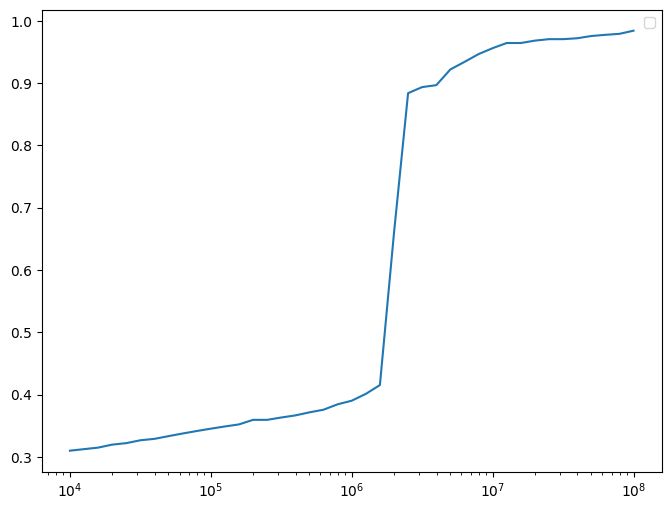

In [167]:
plt.figure(figsize=(8, 6))
plt.plot(output_df["load cost $/MW"], output_df["annual load utilization"])

# Customize the plot
plt.xscale('log')
plt.legend()

In [159]:
initial_output_df

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,1.000000e+04,0.45,-0.44,1.0,90000.0,-88000.0,1.000000e+04,2000.0,1.200000e+04,-6.586761e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,1.258925e+04,0.45,-0.44,1.0,90000.0,-88000.0,1.258925e+04,2000.0,1.458925e+04,-6.794290e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,1.584893e+04,0.45,-0.44,1.0,90000.0,-88000.0,1.584893e+04,2000.0,1.784893e+04,-7.055555e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,1.995262e+04,0.45,-0.44,1.0,90000.0,-88000.0,1.995262e+04,2000.0,2.195262e+04,-7.384467e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,2.511886e+04,0.45,-0.44,1.0,90000.0,-88000.0,2.511886e+04,2000.0,2.711886e+04,-7.798544e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,3.162278e+04,0.45,-0.44,1.0,90000.0,-88000.0,3.162278e+04,2000.0,3.362278e+04,-8.319835e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,3.981072e+04,0.45,-0.44,1.0,90000.0,-88000.0,3.981072e+04,2000.0,4.181072e+04,-8.976102e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,5.011872e+04,0.45,-0.44,1.0,90000.0,-88000.0,5.011872e+04,2000.0,5.211872e+04,-9.802293e+05,-0.44,0.45,-0.1980,2.222222
0,200000,200000,6.309573e+04,0.45,-0.44,1.0,90000.0,-88000.0,6.309573e+04,2000.0,6.509573e+04,-1.084241e+06,-0.44,0.45,-0.1980,2.222222
0,200000,200000,7.943282e+04,0.45,-0.44,1.0,90000.0,-88000.0,7.943282e+04,2000.0,8.143282e+04,-1.215183e+06,-0.44,0.45,-0.1980,2.222222


In [ ]:
from scipy.optimize import minimize

def find_minimum_system_cost(
    solarcost: float,
    batterycost: float,
    loadcost: float,
    sol: np.array
) -> tuple[list[float], list[float], list[float], list[float], list[float]]:
    """
    Finds the optimal system configuration using scipy.optimize.minimize to minimize cost per productivity.
    
    Parameters:
    solarcost (float): Cost per MW of solar array ($/MW).
    batterycost (float): Cost per MWh of battery ($/MWh).
    loadcost (float): Cost per MW of load ($/MW).
    sol (List[float] | np.ndarray): Solar generation profile (MW, normalized for 1 MW array).
    
    Returns:
    Tuple[List[float], List[float], List[float], List[float], List[float]]: 
        - Input costs: [solarcost, batterycost, loadcost]
        - Sizes: [arraysize, batterysize, 1.0]
        - Component costs: [solarcost * arraysize, batterycost * batterysize, loadcost]
        - Total costs: [array + battery cost, total system cost, cost per productivity]
        - Uptime output: [batterysize/arraysize, 1/arraysize, uptime, utilization]
    """
    # Initial guess for arraysize and batterysize, based on original heuristics
    ai = min(10.0, 1.0 + 9.0 * loadcost / 5000000)
    bi = min(10.0, 10.0 * loadcost / 5000000)
    x0 = np.array([ai, bi])
    
    # Define objective function for minimization
    def objective(x: np.array, solarcost: float, batterycost: float, loadcost: float, sol: np.array) -> float:
        arraysize, batterysize = x
        if arraysize <= 0 or batterysize < 0:
            return np.inf  # Penalize invalid values
        return all_in_system_cost(solarcost, batterycost, loadcost, batterysize, arraysize, sol)
    
    # Define bounds: arraysize > 0, batterysize >= 0
    bounds = [(0.01, None), (0.0, None)]
    
    # Run optimization
    result = minimize(
        fun=objective,
        x0=x0,
        args=(solarcost, batterycost, loadcost, sol),
        method='SLSQP',
        bounds=bounds,
        options={'maxiter': 10, 'disp': False}
    )
    
    # Extract optimized values
    print(result.x)
    aimin, bimin = result.x
    costmin = result.fun
    
    # Compute Uptime for final configuration
    ut = uptime_with_battery(np.array([bimin / aimin]), np.array([1 / aimin]), sol)
    ut_row = ut.iloc[0][['capacity', 'load', 'uptime', 'utilization']].tolist()
    
    return (
        [solarcost, batterycost, loadcost],
        [aimin, bimin, 1.0],
        [solarcost * aimin, batterycost * bimin, loadcost],
        [solarcost * aimin + batterycost * bimin, 
         solarcost * aimin + batterycost * bimin + loadcost, 
         costmin],
        ut_row
    )

In [69]:
%%time
sol = df["power_mw"]
result = find_minimum_system_cost(200000, 200000, 5000000, sol)
print(result)

[ 0.31129509 12.31008525]
([200000, 200000, 5000000], [np.float64(0.3112950878494135), np.float64(12.31008525083464), 1.0], [np.float64(62259.0175698827), np.float64(2462017.0501669277), 5000000], [np.float64(2524276.0677368105), np.float64(7524276.06773681), 7878849.153205076], [39.54474622737877, 3.2123860575780814, 0.9531392694063927, 0.9549968429940016])
CPU times: user 1min 54s, sys: 289 ms, total: 1min 54s
Wall time: 1min 54s


In [70]:
%%time
sol = df["power_mw"][:len(df["power_mw"])//2]
result = find_minimum_system_cost(200000, 200000, 5000000, sol)
print(result)

[ 0.30793287 20.82617524]
([200000, 200000, 5000000], [np.float64(0.3079328727483347), np.float64(20.826175238303723), 1.0], [np.float64(61586.57454966694), np.float64(4165235.0476607447), 5000000], [np.float64(4226821.622210411), np.float64(9226821.622210411), 10190763.073395276], [67.6321922126333, 3.2474610166653863, 0.9027016742770168, 0.9054102774991012])
CPU times: user 53.2 s, sys: 202 ms, total: 53.4 s
Wall time: 53.7 s


In [323]:
pd.read_csv("reference/NorthTexas2.csv")

,solar cost $/MW,battery cost $/MWh,load cost $/MW,arraysize (MW),battery size (MWh),load size (1 MW by definition),array cost $,battery cost $,load cost $ (all normalized to 1 MW),total power system cost $,total system cost $,total system cost per utilization,battery size relative to 1 MW array,load size relative to 1 MW array,annual battery utilization,annual load utilization
0,200000,200000,1.000000e+03,1.043255,0.000000,1.0,2.086510e+05,0.000000e+00,1.000000e+03,2.086510e+05,2.096510e+05,1.052468e+06,0.000000,0.958538,0.000048,0.199199
1,200000,200000,1.000000e+04,1.213295,0.000000,1.0,2.426591e+05,0.000000e+00,1.000000e+04,2.426591e+05,2.526591e+05,1.091915e+06,0.000000,0.824202,0.004100,0.231391
2,200000,200000,1.258925e+04,1.229319,0.000000,1.0,2.458638e+05,0.000000e+00,1.258925e+04,2.458638e+05,2.584531e+05,1.102941e+06,0.000000,0.813458,0.005251,0.234331
3,200000,200000,1.584893e+04,1.243668,0.000000,1.0,2.487337e+05,0.000000e+00,1.584893e+04,2.487337e+05,2.645826e+05,1.116665e+06,0.000000,0.804073,0.006516,0.236940
4,200000,200000,1.995262e+04,1.263295,0.000000,1.0,2.526591e+05,0.000000e+00,1.995262e+04,2.526591e+05,2.726117e+05,1.133707e+06,0.000000,0.791581,0.008847,0.240460
5,200000,200000,2.511886e+04,1.285518,0.000000,1.0,2.571037e+05,0.000000e+00,2.511886e+04,2.571037e+05,2.822226e+05,1.154932e+06,0.000000,0.777896,0.011406,0.244363
6,200000,200000,3.162278e+04,1.300120,0.000000,1.0,2.600240e+05,0.000000e+00,3.162278e+04,2.600240e+05,2.916467e+05,1.181372e+06,0.000000,0.769160,0.013813,0.246871
7,200000,200000,3.981072e+04,1.313181,0.000000,1.0,2.626363e+05,0.000000e+00,3.981072e+04,2.626363e+05,3.024470e+05,1.214296e+06,0.000000,0.761509,0.016210,0.249072
8,200000,200000,5.011872e+04,1.326388,0.000000,1.0,2.652776e+05,0.000000e+00,5.011872e+04,2.652776e+05,3.153964e+05,1.255334e+06,0.000000,0.753927,0.018997,0.251245
9,200000,200000,6.309573e+04,1.350757,0.000000,1.0,2.701514e+05,0.000000e+00,6.309573e+04,2.701514e+05,3.332471e+05,1.306283e+06,0.000000,0.740326,0.024524,0.255111
